# In this notebook, we are going to implement MLP model to analysis the data
## https://en.wikipedia.org/wiki/Convolutional_neural_network


In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os
import pandas as pd
from PIL import Image


In [2]:
df = pd.read_csv('input/HAM10000_metadata.csv', delimiter=',')
df.dataframeName = 'HAM10000_metadata.csv'

In [3]:
#preprocess labels
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
label_encoder.fit(df['dx'])
print(list(label_encoder.classes_))
df['label'] = label_encoder.transform(df["dx"])
print(df.sample(5))

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
        lesion_id      image_id   dx    dx_type   age     sex  \
1407  HAM_0006651  ISIC_0032182  mel      histo  70.0  female   
2740  HAM_0005410  ISIC_0025433  bcc      histo  50.0    male   
6533  HAM_0005741  ISIC_0027222   nv  follow_up  40.0    male   
5633  HAM_0006704  ISIC_0025464   nv  follow_up  50.0    male   
4837  HAM_0000084  ISIC_0028036   nv  follow_up  70.0    male   

         localization  label  
1407             back      4  
2740  lower extremity      1  
6533            trunk      5  
5633  lower extremity      5  
4837          abdomen      5  


# features to label
akiex -> 0
bcc -> 1
bkl -> 2
df -> 3
mel -> 4
nv -> 5
vasc -> 6

In [4]:
features_dict = {0:"akiex",1:"bcc",2:"bkl",3:"df",
                 4:"mel",5:"nv",6:"vasc"}

labels = ['akiec','bcc','bkl','df','mel','nv','vasc']

In [5]:
import math
#assign weight
#sum of the data
total_data = 0
num_classes = 7
for num_of_data in df['label'].value_counts():
    total_data+=num_of_data
print("total number of data: ",total_data)
print(df['label'].value_counts())
#calc weight for each class
class_weight ={}
for index, value in df.label.value_counts().iteritems():
    v1 = math.log(total_data/(float(value)*num_classes))
    class_weight[index] = v1 if v1>1.0 else 1.0

for i in class_weight:
    print(i," ",class_weight[i])

total number of data:  10015
5    6705
4    1113
2    1099
1     514
0     327
6     142
3     115
Name: label, dtype: int64
5   1.0
4   1.0
2   1.0
1   1.0237058335894402
0   1.4759689281473518
6   2.310102041443345
3   2.520996970681355


In [6]:
from glob import glob
image_size = 32 #the size that the image will resize to
image_path = {os.path.splitext(os.path.basename(x))[0]: x
              for x in glob(os.path.join('input/','*','*.jpg'))}
#image path
df['path'] = df['image_id'].map(lambda id: image_path.get(id))

In [7]:
#image_64 is the actual image(resized to 64x64) store in the dataframe
#it takes time to process the image
df['image_64'] = df['path'].map(lambda path:Image.open(path).resize((image_size,image_size)))

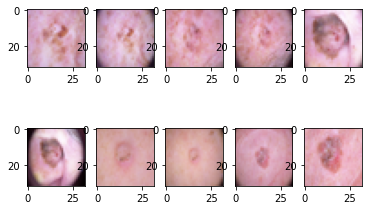

In [8]:
#print some image
index = 1
for image in df['image_64'].head(10):
    plots = plt.subplot(2,5,index)
    plots.imshow(image)
    index+=1

In [9]:
#image to array
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from sklearn.model_selection import StratifiedShuffleSplit,train_test_split

df['image'] = df['image_64'].map(lambda image: np.asarray(image))
data = np.asarray(df['image'].to_list())
data = data.reshape(total_data,image_size*image_size*3).astype('float32')
data = data/255.0 #normalise the RGB value to [0...1]
label_to_one_hot = to_categorical(df['label'], num_classes=7)
#80% data for training
#20% data for testing
import random
train_data,test_data,train_label,test_label = train_test_split(data,label_to_one_hot,test_size=0.2,random_state=87,stratify=label_to_one_hot)


In [10]:
#setup MLP model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout,Dense
num_classes = 7
dimension = image_size*image_size*3

model_MLP_V1 = Sequential()

#input Dense layer of 64x64x3 image input:
#with normal distribution + relu activation
model_MLP_V1.add(Dense(units=2048,input_dim=dimension,kernel_initializer='normal',activation='relu'))
model_MLP_V1.add(Dropout(0.1))

#hidden layer 2
model_MLP_V1.add(Dense(units=1024,input_dim=dimension,kernel_initializer='normal',activation='relu'))
model_MLP_V1.add(Dropout(0.1))

#hidden layer 3
model_MLP_V1.add(Dense(units=512,input_dim=dimension,kernel_initializer='normal',activation='relu'))
model_MLP_V1.add(Dropout(0.1))

#hidden layer 4
model_MLP_V1.add(Dense(units=256,input_dim=dimension,kernel_initializer='normal',activation='relu'))
model_MLP_V1.add(Dropout(0.1))

#output Dense layer with 7 classes + softmax activation
model_MLP_V1.add(Dense(units=num_classes,kernel_initializer='normal',activation='softmax'))
model_MLP_V1.summary()

model_MLP_V1.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['acc'])


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 2048)              6293504   
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               1

In [11]:
# Train
try:
    model_MLP_V1.load_weights('model/MLP_weight.h5')
except:
    print("new model_MLP_V1")

batch_size = 512
epochs = 200

train_history = model_MLP_V1.fit(
    x=train_data,y=train_label,
    epochs=epochs,
    batch_size = batch_size,
    validation_split=0.2,
    verbose=2,class_weight=class_weight)

new model_MLP_V1
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/200
13/13 - 1s - loss: 3.8735 - acc: 0.4881 - val_loss: 1.2892 - val_acc: 0.6569
Epoch 2/200
13/13 - 0s - loss: 1.5018 - acc: 0.6427 - val_loss: 1.2178 - val_acc: 0.6569
Epoch 3/200
13/13 - 0s - loss: 1.3602 - acc: 0.6716 - val_loss: 1.1704 - val_acc: 0.6569
Epoch 4/200
13/13 - 0s - loss: 1.3136 - acc: 0.6728 - val_loss: 1.1204 - val_acc: 0.6569
Epoch 5/200
13/13 - 0s - loss: 1.2629 - acc: 0.6716 - val_loss: 1.0882 - val_acc: 0.6581
Epoch 6/200
13/13 - 0s - loss: 1.2358 - acc: 0.6708 - val_loss: 1.0580 - val_acc: 0.6569
Epoch 7/200
13/13 - 0s - loss: 1.2128 - acc: 0.6705 - val_loss: 1.0805 - val_acc: 0.6569
Epoch 8/200
13/13 - 0s - loss: 1.1831 - acc: 0.6726 - val_loss: 1.0655 - val_acc: 0.6569
Epoch 9/200
13/13 - 0s - loss: 1.1642 - acc: 0.6722 - val_loss: 1.0292 - val_acc: 0.6569
Epoch 10/200
13/13 - 0s - loss: 1.1662 - acc

In [12]:
model_MLP_V1.save_weights('model/MLP_weight.h5')
model_MLP_V1.save('model/MLP_V1.h5')

In [13]:
# apply oversampling instead of class weight
from imblearn.over_sampling import SMOTE
smote_sample = SMOTE(random_state=87)
train_data_oversample, train_label_oversample = smote_sample.fit_resample(train_data, train_label)

C:\Users\andre\anaconda3\envs\cmpt340_conda\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=[0 1 2 3 4 5 6] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


In [14]:
#setup MLP model V2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout,Dense
num_classes = 7
dimension = image_size*image_size*3

model_MLP_V2 = Sequential()

#input Dense layer of 64x64x3 image input:
#with normal distribution + relu activation
model_MLP_V2.add(Dense(units=2048,input_dim=dimension,kernel_initializer='normal',activation='relu'))
model_MLP_V2.add(Dropout(0.2))

#hidden layer 2
model_MLP_V2.add(Dense(units=1024,input_dim=dimension,kernel_initializer='normal',activation='relu'))
model_MLP_V2.add(Dropout(0.3))

#hidden layer 3
model_MLP_V2.add(Dense(units=512,input_dim=dimension,kernel_initializer='normal',activation='relu'))
model_MLP_V2.add(Dropout(0.3))

#hidden layer 4
model_MLP_V2.add(Dense(units=256,input_dim=dimension,kernel_initializer='normal',activation='relu'))
model_MLP_V2.add(Dropout(0.3))

#output Dense layer with 7 classes + softmax activation
model_MLP_V2.add(Dense(units=num_classes,kernel_initializer='normal',activation='softmax'))
model_MLP_V2.summary()

model_MLP_V2.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['acc'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 2048)              6293504   
_________________________________________________________________
dropout_4 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dropout_5 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 256)              

In [15]:
# Train
try:
    model_MLP_V2.load_weights('model/MLP_V2_weight.h5')
except:
    print("new model_MLP_V2")

new model_MLP_V2
Epoch 1/200
59/59 - 1s - loss: 2.2312 - acc: 0.1902 - val_loss: 3.1292 - val_acc: 0.0000e+00
Epoch 2/200
59/59 - 0s - loss: 1.6934 - acc: 0.2756 - val_loss: 3.8903 - val_acc: 0.0000e+00
Epoch 3/200
59/59 - 0s - loss: 1.5911 - acc: 0.3153 - val_loss: 4.4858 - val_acc: 0.1091
Epoch 4/200
59/59 - 0s - loss: 1.5370 - acc: 0.3473 - val_loss: 3.4749 - val_acc: 0.1610
Epoch 5/200
59/59 - 0s - loss: 1.4875 - acc: 0.3696 - val_loss: 4.6314 - val_acc: 0.1256
Epoch 6/200
59/59 - 0s - loss: 1.4569 - acc: 0.3926 - val_loss: 4.1657 - val_acc: 0.1406
Epoch 7/200
59/59 - 0s - loss: 1.4124 - acc: 0.4175 - val_loss: 3.8531 - val_acc: 0.0997
Epoch 8/200
59/59 - 0s - loss: 1.3901 - acc: 0.4346 - val_loss: 4.1384 - val_acc: 0.1322
Epoch 9/200
59/59 - 0s - loss: 1.3690 - acc: 0.4483 - val_loss: 4.3468 - val_acc: 0.0735
Epoch 10/200
59/59 - 0s - loss: 1.3399 - acc: 0.4683 - val_loss: 4.3190 - val_acc: 0.1133
Epoch 11/200
59/59 - 0s - loss: 1.3184 - acc: 0.4757 - val_loss: 3.8531 - val_acc: 0

In [ ]:
batch_size = 512
epochs = 200

train_history_2 = model_MLP_V2.fit(
    x=train_data_oversample,y=train_label_oversample,
    epochs=epochs,
    batch_size = batch_size,
    validation_split=0.2,
    verbose=2, shuffle=True)

In [16]:
model_MLP_V2.save_weights('model/MLP_V2_weight.h5')
model_MLP_V2.save('model/MLP_V2.h5')

In [17]:
def plot_train_history(t_history, train,validation):
    plt.plot(t_history.history[train])
    plt.plot(t_history.history[validation])
    plt.title("train_history")
    plt.ylabel(train)
    plt.xlabel("epochs")
    plt.legend(['train','validation'],loc='upper left')
    plt.show()

MLP V1


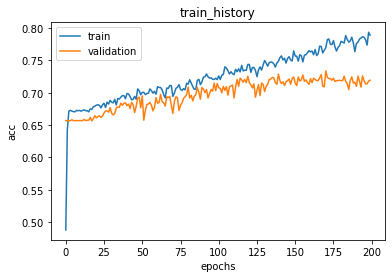

MLP V2


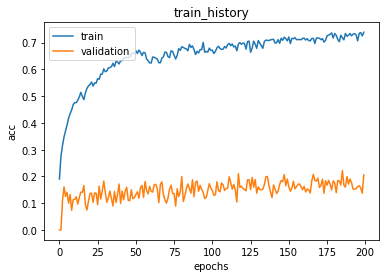

In [18]:
#plot train history
print("MLP V1")
plot_train_history(train_history,'acc','val_acc')
print("MLP V2")
plot_train_history(train_history_2,'acc','val_acc')

MLP V1


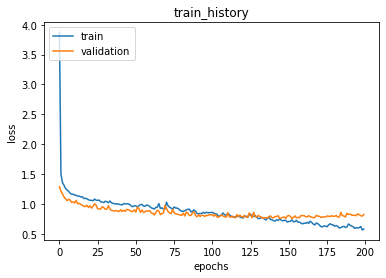

MLP V2


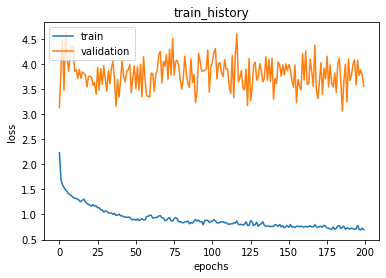

In [19]:
# plot loss
print("MLP V1")
plot_train_history(train_history,'loss','val_loss')
print("MLP V2")
plot_train_history(train_history_2,'loss','val_loss')

In [20]:
#score
score = model_MLP_V1.evaluate(test_data, test_label)
print('Test accuracy:', score[1])

score_2 = model_MLP_V2.evaluate(test_data, test_label)
print('Test accuracy:', score_2[1])

63/63 [==============================] - 0s 2ms/step - loss: 0.8269 - acc: 0.7249
Test accuracy: 0.7249126434326172
63/63 [==============================] - 0s 2ms/step - loss: 1.3064 - acc: 0.5102
Test accuracy: 0.5102346539497375


In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
def print_confusion_matrix(model):
    score = model.evaluate(test_data, test_label)
    print('Test accuracy:', score[1])

    prediction = model.predict(test_data)
    prediction_class = np.argmax(prediction,axis=1)
    prediction_label = np.argmax(test_label,axis=1)

    mapping = lambda x:features_dict[x]
    pred_class_to_feature = np.array([mapping(x) for x in prediction_class])
    pred_label_to_feature = np.array([mapping(x) for x in prediction_label])
    matrix = confusion_matrix(pred_label_to_feature,pred_class_to_feature)
    matrix_display = ConfusionMatrixDisplay(matrix)
    fig,x = plt.subplots(figsize =(12,12))
    matrix_display.plot(ax=x)
    print(classification_report(pred_label_to_feature,pred_class_to_feature,target_names=labels))
    #print(pd.crosstab(pred_label_to_feature,pred_class_to_feature,colnames=['predicted']))

MLP V1
predicted  akiex  bcc  bkl  df  mel    nv  vasc
actual                                         
akiex         23   13    8   4    6    11     0
bcc           12   43    8   4    8    23     5
bkl           13   13   78   4   15    94     3
df             2    4    0   5    2     9     1
mel            4    7   27   2   30   149     4
nv            10   12   28   6   19  1261     5
vasc           3    1    2   0    3     7    12
MLP V2
predicted  akiex  bcc  bkl  df  mel   nv  vasc
actual                                        
akiex         22    9   26   0    6    2     0
bcc           23   38   33   4    2    3     0
bkl           13    6  159   1   29   12     0
df             5    3   13   1    0    1     0
mel            8    3   76   3   98   35     0
nv            15   15  378   6  224  703     0
vasc           4    6    4   1    4    8     1


In [ ]:
print("V1")
print_confusion_matrix(model_MLP_V1)
print("V2")
print_confusion_matrix(model_MLP_V2)